In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt                    
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
arch='D:\Descargas\Escuela\Semestre actual\Practicas profesiónales\Inf1.csv'
df = pd.read_csv(arch)

In [3]:
df.head()

,Mes,InfSub
0,1982-01,3.929378
1,1982-02,4.271213
2,1982-03,4.278975
3,1982-04,5.763558
4,1982-05,6.210453


In [4]:
df.Month = pd.to_datetime(df.Mes)
df = df.set_index("Mes")
df.head()

,InfSub
Mes,
1982-01,3.929378
1982-02,4.271213
1982-03,4.278975
1982-04,5.763558
1982-05,6.210453


In [5]:
df.index.freq = 'MS'

In [6]:
#ax = df['InfSub'].plot(figsize = (16,5), title = "InfSub")
#ax.set(xlabel='Mes', ylabel='Inflación Subyacente');

In [7]:
train_data = df[:len(df)-24]
test_data = df[len(df)-24:]

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [9]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator

# Let's redefine to get 12 months back and then predict the next month out
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, 
                                length=n_input, batch_size=1)

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

lstm_model = Sequential()
lstm_model.add(LSTM(300, activation='tanh',return_sequences=True,
                    input_shape=(n_input, n_features)))
lstm_model.add(LSTM(250, activation='tanh', return_sequences=True))
lstm_model.add(LSTM(200, activation='tanh', return_sequences=True))
lstm_model.add(Dense(1))
#Permite guardar el modelo una vez que se esta entrenado con la mejor convinación de parametros
mc = ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', mode='min', 
                     verbose=1, save_best_only=True)

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 300)           362400    
                                                                 
 lstm_1 (LSTM)               (None, 12, 250)           551000    
                                                                 
 lstm_2 (LSTM)               (None, 12, 200)           360800    
                                                                 
 dense (Dense)               (None, 12, 1)             201       
                                                                 
Total params: 1,274,401
Trainable params: 1,274,401
Non-trainable params: 0
_________________________________________________________________


In [12]:
lstm_model.compile(optimizer='adam', loss='mse')

In [13]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
432/432 [==============================] - 23s 44ms/step - loss: 0.0176
Epoch 2/20
432/432 [==============================] - 19s 44ms/step - loss: 0.0126
Epoch 3/20
432/432 [==============================] - 23s 53ms/step - loss: 0.0104
Epoch 4/20
432/432 [==============================] - 21s 47ms/step - loss: 0.0116
Epoch 5/20
432/432 [==============================] - 21s 48ms/step - loss: 0.0101
Epoch 6/20
432/432 [==============================] - 23s 54ms/step - loss: 0.0101
Epoch 7/20
432/432 [==============================] - 21s 49ms/step - loss: 0.0099
Epoch 8/20
432/432 [==============================] - 19s 43ms/step - loss: 0.0102
Epoch 9/20
432/432 [==============================] - 19s 44ms/step - loss: 0.0099
Epoch 10/20
432/432 [==============================] - 18s 42ms/step - loss: 0.0091
Epoch 11/20
432/432 [==============================] - 18s 42ms/step - loss: 0.0183
Epoch 12/20
432/432 [==============================] - 18s 42ms/step - loss: 0.0127
E

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=6)

In [16]:
validation_generator = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input)

In [17]:
lstm_model.compile(optimizer='adam', 
              loss='mse')

In [18]:
# fit model
lstm_model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop, mc])

Epoch 1/20
432/432 [==============================] - ETA: 0s - loss: 0.0126
Epoch 00001: val_loss improved from inf to 0.00268, saving model to best_model_lstm.h5
432/432 [==============================] - 23s 46ms/step - loss: 0.0126 - val_loss: 0.0027
Epoch 2/20
432/432 [==============================] - ETA: 0s - loss: 0.0110
Epoch 00002: val_loss improved from 0.00268 to 0.00027, saving model to best_model_lstm.h5
432/432 [==============================] - 19s 43ms/step - loss: 0.0110 - val_loss: 2.6695e-04
Epoch 3/20
431/432 [============================>.] - ETA: 0s - loss: 0.0098
Epoch 00003: val_loss did not improve from 0.00027
432/432 [==============================] - 19s 44ms/step - loss: 0.0098 - val_loss: 4.1666e-04
Epoch 4/20
431/432 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 00004: val_loss improved from 0.00027 to 0.00016, saving model to best_model_lstm.h5
432/432 [==============================] - 19s 43ms/step - loss: 0.0083 - val_loss: 1.6190e

<AxesSubplot:>

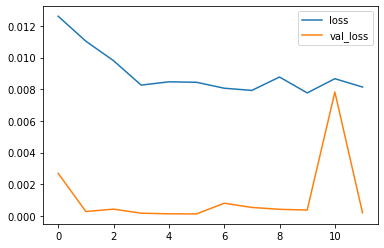

In [19]:
losses = pd.DataFrame(lstm_model.history.history)
losses.plot()

In [20]:
from keras.models import load_model

lstm_model = load_model('best_model_lstm.h5', compile=False)

In [21]:
pred_list=[]

batch = scaled_train_data[-n_input:].reshape((1,n_input,n_features,))

for i in range(n_input):
    pred_list.append(lstm_model.predict(batch)[0])
    batch1 =np.append(batch[:,1:,:],[pred_list[i]], axis=1)

In [22]:
pred_list[0]

array([[0.0210633 ],
       [0.03237392],
       [0.02829261],
       [0.02991673],
       [0.03049357],
       [0.03062621],
       [0.03068785],
       [0.03074107],
       [0.03079273],
       [0.03084423],
       [0.03089575],
       [0.03094672]], dtype=float32)

In [23]:
lstm_predictions = scaler.inverse_transform(pred_list[0])

In [24]:
lstm_predictions

array([[0.24587625],
       [0.3956073 ],
       [0.34157857],
       [0.36307883],
       [0.37071508],
       [0.37247092],
       [0.373287  ],
       [0.37399143],
       [0.37467533],
       [0.37535706],
       [0.3760392 ],
       [0.37671384]], dtype=float32)

In [25]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    lstm_pred = lstm_model.predict(current_batch)[0]
    
    # store prediction
    lstm_predictions_scaled.append(lstm_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred[0]]],axis=1)

In [26]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled[0])

In [27]:
lstm_predictions

array([[0.24587625],
       [0.3956073 ],
       [0.34157857],
       [0.36307883],
       [0.37071508],
       [0.37247092],
       [0.373287  ],
       [0.37399143],
       [0.37467533],
       [0.37535706],
       [0.3760392 ],
       [0.37671384]], dtype=float32)

In [28]:
test_dataa = df[len(df)-12:]
test_dataa['LSTM_Predictions'] = lstm_predictions

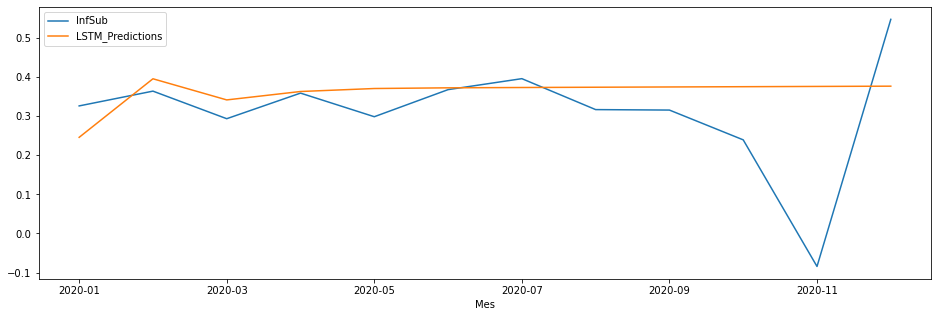

In [29]:
test_dataa['InfSub'].plot(figsize = (16,5), legend=True)
test_dataa['LSTM_Predictions'].plot(legend = True);

In [33]:
lstm_rmse_error = rmse(test_dataa['InfSub'], test_dataa["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['InfSub'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 0.02348436617723191
RMSE Error: 0.1532460967764984
Mean: 1.5532881589743583
